## In Class Activity 1

- Cluster the penguins data into 3 clusters
- Visualize the clusters across all features using `sns.pairplot()`
    - add your clusters as a new column of the dataframe with `df_penguin['cluster'] = y` or similar
- Which features does the clustering do a great job of seperating?  Why?  
    - hint: maybe we should do scale normalization across our features first ...

In [16]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
    
df_penguin = sns.load_dataset('penguins')
df_penguin.dropna(axis=0, inplace=True, how='any')
    
df_penguin.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


<Figure size 432x288 with 0 Axes>

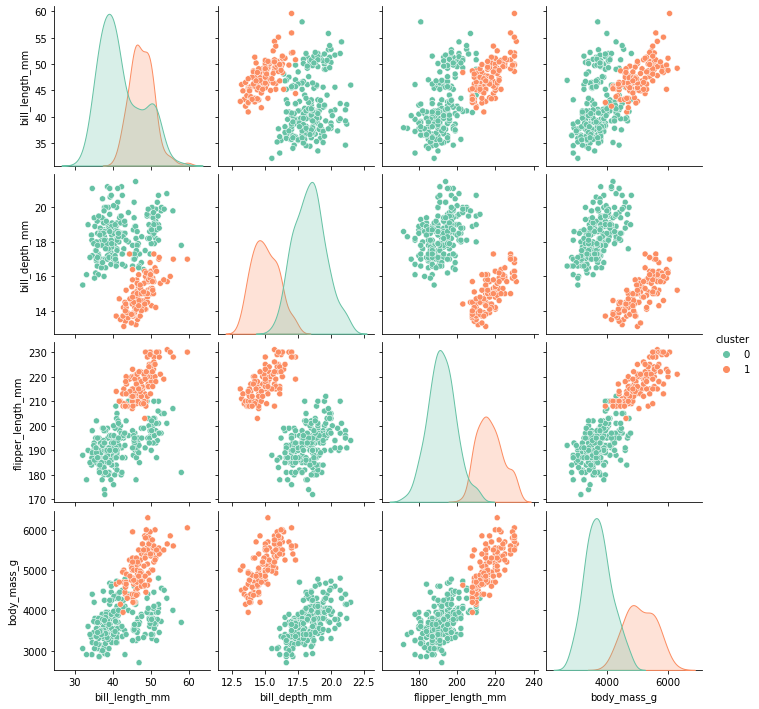

<Figure size 432x288 with 0 Axes>

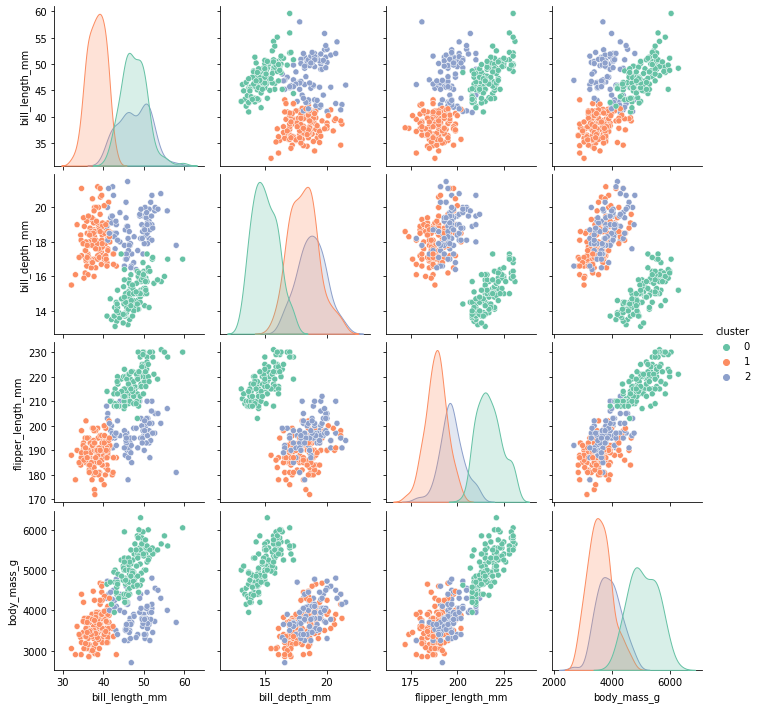

<Figure size 432x288 with 0 Axes>

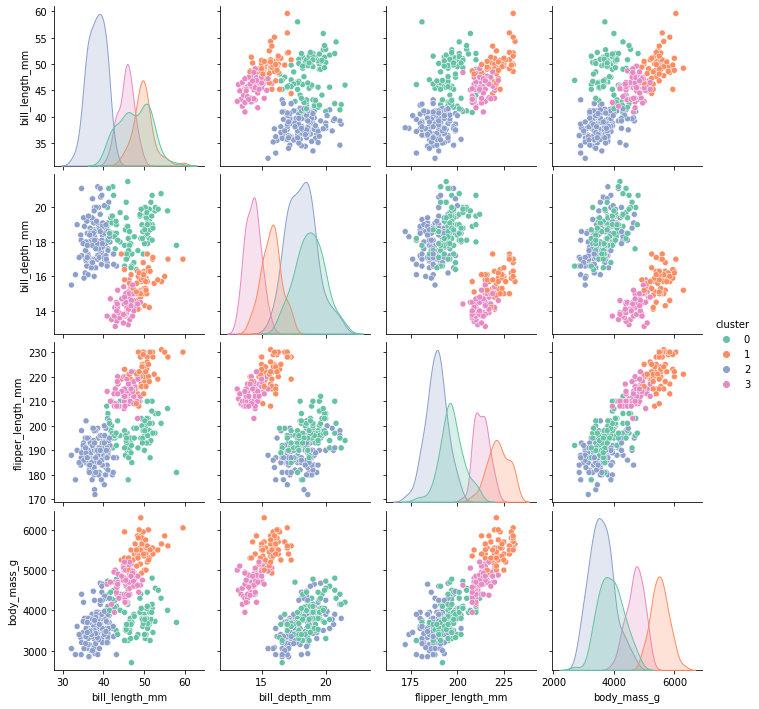

In [17]:
# extract features
x_feat_list = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
x = df_penguin.loc[:, x_feat_list].values

# scale normalization
x = x @ np.diag(1 / x.std(axis=0))

mean_d_dict = dict()
for n_clusters in range(2, 5):
    
    # fit kmeans
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    y = kmeans.predict(x)

    # computing and storing mean distance
    mean_d = -kmeans.score(x)
    mean_d_dict[n_clusters] = mean_d
    
    # plot pairplot
    plt.figure()
    plt.suptitle(f'{n_clusters} clusters has mean_d: {mean_d:.1e}')
    df_penguin['cluster'] = y
    sns.pairplot(data=df_penguin, hue='cluster', palette='Set2')
    

# ICA 2

Estimate a polynomial fit for each y in `xy_poly.csv`.  
- as above, make a plot of the cross validated r2 vs degree and scatter/model per polynomial
- will this procedure always get the "right" polynomial order?  Why or why not?
- (extra) place your plots in a 2x2 subplot area via
    - `fig, axs = plt.subplots(2, 2)`
    - `plt.sca(axs[0, 1])`  sets the current axes as top row (0) and the second column (1)

In [30]:
import pandas as pd

df_xy_poly = pd.DataFrame()

# top secret: all these polynomials are really the same: x^5
# we vary the amount of noise addeded to each
coef_snr_list = [(np.array([0, 0, 0, 0, 0, 1]), .1),
                 (np.array([0, 0, 0, 0, 0, 1]), 3)]

x = np.linspace(-1, 1, 201)
df_xy_poly['x'] = x[:]

for poly_idx, (coef, noise_snr) in enumerate(coef_snr_list):
    x, y = get_xy_poly(x, coef, noise_snr)
    df_xy_poly.loc[:, f'y{poly_idx}'] = y[:]

df_xy_poly.to_csv('xy_poly.csv', index=False)

df_xy_poly = pd.read_csv('xy_poly.csv')
df_xy_poly.head()

,x,y0,y1
0,-1.00,-0.996114,-0.883427
1,-0.99,-0.955073,-1.073473
2,-0.98,-0.884128,-0.310144
3,-0.97,-0.855492,-0.761474
4,-0.96,-0.831928,-1.312026


In [31]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
sns.set(font_scale=1.3)

def poly(x, coef):
    """ computes polynomials in x
    
    to represent the polynomial:
    
    a_0 x^0 + a_1 x^1 + a_2 x^2 + a_3 x^3 + ...
    
    coef = [a_0, a_1, a_2, a_3, ...]
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
    """
    # initialize y as array of zeros
    y = np.zeros_like(x)
    
    # adds each monomial one at a time
    for deg, a in enumerate(coef):
        y += a * x ** deg
        
    return y

In [33]:
def get_xy_poly(x, coef, noise_snr):
    """ returns x, y with a noisy polynomial relation
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
        noise_snr (float): scales the noise (real problems
            don't have perfect y = poly(x, coef) relationship)
            
    Returns:
        x (np.array): (n, 1) domain of polynomial
        y (np.array): (n, 1) noisy output of polynomial
    """
    # project x via polynomial
    y = poly(x, coef=coef).flatten()

    # add noise
    rng = np.random.default_rng(seed=0)
    std = noise_snr * np.std(y.flatten())
    noise = rng.normal(size=y.size, scale=std)
    y = y + noise
    
    # ensure 2d x for sklearn (n_samples, n_features)
    x = x.reshape(-1, 1)
    
    return x, y

In [34]:
def fit_plot_poly(x, y, degree):
    """ fits and plots a polynomial of given degree
    
    Args:
        x (np.array): (n_samples, 1) array of x inputs
        y (np.array): (n_sample, 1) array of target values
        degree (int): max degree of polynomial
    """
    
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    x_poly = poly_project.fit_transform(x)
    
    # fit via linear regression
    reg = LinearRegression(fit_intercept=False)
    reg.fit(x_poly, y)
    
    # predict y values (line of polynomial)
    # (we use 101 evenly spaced points as there may be so few
    # observations that the polynomial appears piecewise linear
    # with straight lines between each observation)
    x_fine = np.linspace(x.min(), x.max(), 101).reshape(-1, 1)
    x_fine_poly = poly_project.fit_transform(x_fine)
    y_pred_fine = reg.predict(x_fine_poly)
    
    # compute r2
    y_pred = reg.predict(x_poly)
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    # plot polynomial / observations
    plt.plot(x_fine, y_pred_fine, label=f'degree {degree} r2={r2:.3f}', color='k', linewidth=2)
    plt.scatter(x, y, label='observed', color='r')
    plt.legend()  
    
    return reg

In [35]:
# use KFold for regression and StratifiedKFold for classification
from sklearn.model_selection import KFold

def cross_val_r2(x, y, degree, n_splits=10):
    """ computes cross validated r2 (regression performance on unseen data)
    
    """
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    x_poly = poly_project.fit_transform(x)
        
    # initialize empty y predictions
    y_pred = np.empty_like(y)
    
    # initialize linear regression model
    # fit_intercept=False since we're using poly features
    reg = LinearRegression(fit_intercept=False)
    
    kfold = KFold(n_splits=n_splits)
    for train_idx, test_idx in kfold.split(x_poly, y):
        # split data
        x_poly_test = x_poly[test_idx, :]
        x_poly_train = x_poly[train_idx, :]
        y_train = y[train_idx]
        
        # fit
        reg.fit(x_poly_train, y_train)
        
        # predict
        y_pred[test_idx] = reg.predict(x_poly_test)
        
    # compute cross validated r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    return r2

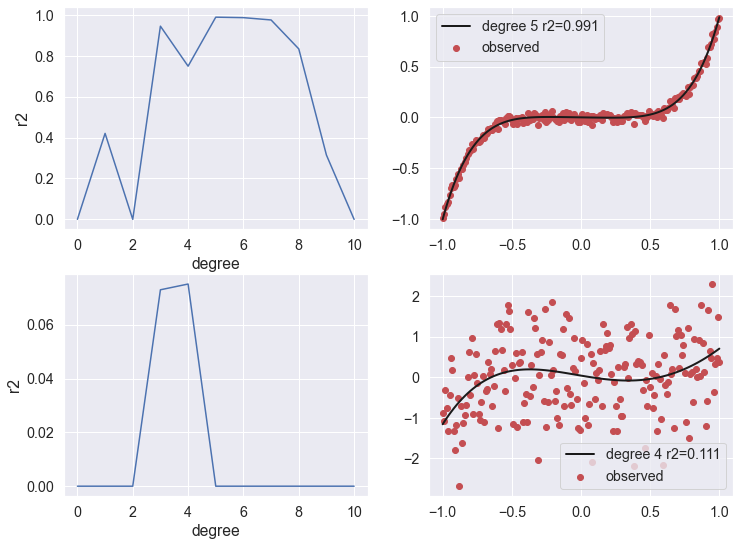

In [36]:
# extract/reshape
x = df_xy_poly['x'].values.reshape(-1, 1)

# initialize plots
fig, axs = plt.subplots(2, 2)

for poly_idx in range(2):
    # get y
    y = df_xy_poly[f'y{poly_idx}'].values
    
    # cross validates r2
    r2_per_degree = list()
    for degree in range(11):
        r2 = cross_val_r2(x, y, degree)
        r2_per_degree.append(r2)
        
    # threshold r2 to be >= 0 
    r2_per_degree = np.maximum(np.array(r2_per_degree), 0)
    
    # plot r2 vs degrees
    plt.sca(axs[poly_idx, 0])
    plt.plot(r2_per_degree)
    plt.xlabel('degree')
    plt.ylabel('r2')
    
    # plot best model fit
    plt.sca(axs[poly_idx, 1])
    degree_best = np.argmax(r2_per_degree)
    fit_plot_poly(x, y, degree_best)
    
fig.set_size_inches(12, 9)